
# CSCI E-25
## Introduction to Convolutional Neural Networks
### Steve Elston

## 1.0 Introduction to convolutional neural networks

This lesson introduces you to a powerful neural network architecture, known as **convolutional neural networks**. Convolutional neural networks operate by **learning a set of filters**  or **convolution kernels**. Using a process, known as **convolution**, these filters extract a **feature map** from the raw data. The feature map is a **lower dimensional** map of the raw input features. This map is learned in a supervised machine learning process employing back propagation. You can think of convolutional neural networks as a powerful and flexible **dimensionality reduction** method. 

Convolutional neural networks are used to build feature maps from any type of data with coherency in one or more dimensions. This includes time series data, and text data as one dimensional cases, and image data as a two dimensional case. 

Convolutional neural networks have a resonably long history. The first known commerical application was for automated processing of check images by LeCun et. al. (1998). For unclear reasons, convolutional neural networks were religated to specialized applications such as hand writing recognition until Krizhevsky et. al. (2012) used them to deciscively win an ImageNet object recognition competition. Curiously, other teams had previously used convolutional neural networks to win competitons, but somehow this was not widely recognized. 

In this lesson you will learn:
1. The basics of convolutional neural network architecture.
2. How convolutional neural networks learn the filters to create the feature map. 
3. Feature extraction for creating the feature map. 
4. Visualization of the feature map and the filters.
5. Commonly used convolutional opertor design. 
6. How to use the feature map in suppervised learning. 
7. Application of various regularization methods for improving the behavior of learning. 

****
**Note:** The formulation of convolution filters used in deep learning is somewhat idiosycratic. If you are familar with the standard approach as applied in say electrical engineering or control engineering you may find the approach used here a bit different. 
****


It is time to import the packages required to execute the code in this notebook. 

In [19]:
import numpy as np
import pandas as pd
import numpy.random as nr
import matplotlib.pyplot as plt
#import keras
from keras import callbacks
import tensorflow as tf
from keras.datasets import mnist
import keras.utils.np_utils as ku
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from keras.optimizers import RMSprop 
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
import sklearn.metrics as metrics
from scipy.stats import rankdata

%matplotlib inline

### 1.1 Applying 2-d convolution

Let's review how we can apply convolution operations in two dimensions. Figure 1.1 illustrates a simple example of applying a convolution operator to a 2-d input array. The 2-d input array can be a gray-scale image, for example. 

A 3X3 convolutional operator is illustrated in Figure 1.1. This operator is applied to a small image of dimension of 4X4 pixels. Within the 4X4 image the operator is only applied four times, where the complete operator lies on the image. Convolution where the operator is completely contained within the input sample is sometimes called call **valid convolution**. 

In this case the 4X4 pixel input results in a 2X2 pixel output. You can think of the convolutional operator mapping from the center of the operator input to pixel in the output. Similar to the 1-d case, for a convolution operator with span $s$ in both dimensions the output array will be reduced in each dimension by $\frac{s + 1}{2}$

![](img/2D-Conv.JPG)
<center>Figure 1.1. Simple 2-d convolution operation</center>

For a convolution with the identical span $s$ in both dimensions we can write the convolution operations as: 

$$S(i,j) = (I * K)(i,j) = \sum_{m = {i - a}}^{i + a} \sum_{n = j - a}^{j + a} I(i, j) K(i-m, j-n)$$

Notice that $S$, $I$ and $K$ are all tensors. Given this fact, the above formula is easily extended to higher dimensional problems. 

The convoluational kernel $K$ and the image $I$ are commutative so there is an alternative representation by applying an operation known as **kernel flipping**. Flipped kernel convolution can be represented as follows:

$$s(i,j) = (I * K)(i,j) = \sum_{m = {i - a}}^{i + a} \sum_{n = j - a}^{j + a} I(i-m, j-n) K(i, j)$$


### 1.2 Convolution in higher dimensions

In deep convolutional neural networks the input typically have several **input channels** with the convolution operation resulting in multiple **output channels**. 

So far, we have only looked at single channel convolution. Here are some examples of input tensors with different numbers of input channels:
- A gray-scale image has a single input channel of pixels. 
- A color image typically has 3 input channels, {Red, Green, Blue}.
- A color movie has a large number of input channels. For $n$ images in the video there are $3 * n$ images counting the Red, Green, Blue channels for each image.  

The purpose of the a convolutional neural network is to create a feature map. To create the most general feature map convolution operators need not be restricted to a single input channel. 

Further, the feature map can can many channels, resulting in multiple output channels. Each channel is a set of features extracted from the input tensor. This concept is illustrated in Figure 1.2 below. In this figure a set of convolution operators transform the input tensors to multiple channels of the feature map. Each convolution operator maps to a specific output channel in the feature map. 

![](img/MultiChannel.JPG)
<center>Figure 1.2. Example of multichannel convolution</center>

Let's investigate the case of a 3-d input tensor $V$, a 3-d output tensor $Z$ and 4-d convolution tensor $K$. In this case the convolution equation becomes:

$$Z_{i,j,k} = (V * Z)(i,j,k,l) = \sum_{l} \sum_{m = -a}^{a}
\sum_{n = -a}^{a}
V_{i,j,l} \cdot K_{i-m,j-n,k,l}$$
where,  
$i,j$ are the spatial dimensions,  
$k$ is the index of the output channel,  
$l$ is the index of the input channel,  
$K_{i,j,k,l}$ is the kernel connecting the $l$th channel of the input to the $k$th channel of the output for pixel offsets $i$ and $j$    
$V_{i,j,l}$ is the $i,j$ input pixel offsets from channel $l$ of the input,  
$Z_{i,j,k}$ is the $ i,j$ pixel offsets from channel $k$ of the output,  
$a = \frac{1}{2}(kernel\_span + 1)$, for an odd length kernel.  

Notice that the summation in the equation above is over input channels $l$ as well as the spatial dimensions $m,n$ of the convolutional operator. This operation is applied for each spatial pixel coordinate $i,j$. This generalization allows the convolutional kernel to operate over multiple input channels. This is property is highly desirable since features should be extracted from the entire input tensor. 

The entire forgoing operation is performed for each output channel $k$. Therefore, you can think of the $k$th dimension of the 4-d kernel tensor as indexing multiple 3-d convolution kernels. 

### 1.3 Parameter sharing and sparse interactions

**Parameter sharing** and **sparse interactions** are two powerful aspects of convolutional neural networks. To understand what these terms mean and why they are important, consider the fully connected neural network in Figure 1.3 below.  
![](img/FullyConnected.JPG)
<center>Figure 1.3. A fully connected network</center>

The fully connected neural network has a large number of weights, $5^2 = 25$ in this case. Compare this network to the convolutional layer with $2 \times 2$ operator will have only $2*2 = 4$ weights. For a more realistic case, the fully connected network might have millions of weights. The convolutional network using **weight sharing** across the entire layer. For a $5 \times 5$ CovNet layer there are only $5 * 5 = 25$ weights. Parameter sharing is also referred to as **tied weights**. This is an example of a **sparse interaction**.

The shared nature of the parameters in convolutional neural networks is a significant reduction in complexity. Statistically, such a sparse model is said to **share statistical strength**. This statistical strength results in model weights with less uncertainty and a model less likely to be over-fit.  

The computational efficiency of convolutional neural networks is not just in training. Convolutional neural networks are also efficient for creating **rich feature maps** which lead to high levels of accuracy in production.

### 1.4 Pooling and invariance

To further reduce dimensionality and to make the feature map robust to small shifts in the input, **pooling** is applied following the nonlinear detection stage. Pooling involves applying an aggregation function to patches of the output from the nonlinear detector of a convolution layer. 

Researchers have tried a number of pooling schemes. In practice **max pooling** (Zhou and Chellappa, 1988) has proved to be both robust and versatile. In max pooling the output value is just the maximum of the input values in each patch. 

Unlike convolutional layers, there are no parameters to learn in pooling layers. 

Max pooling has the nice property of being robust to small shifts in the input values. For example, Figure 1.4 shows the response of max pooling to a right sift of a single pixel for an operator with a span of 3. Notice that the response itself is simply shifted one pixel to the right as well. The pattern of maximum values in the feature map (the output) remains the same. 

![](img/ShiftOne.JPG)
<center>Figure 1.4.   
    Example of max pooling responses to one pixel shift right</center>

### 1.5 Stride and tiling

Up until now, we have only moved the convolution operator one pixel at a time. There is no restriction that requires this type of step, however. In fact, a convolutional operator or pooling opertor can be moved by several pixels in any direction. This step size is known as the **stride** of the operator. 

Operators with stride greater than one **decimate** the number of pixels in the output. This can be useful when resizing images of different dimensions so they have constant input dimensions for a neural network. 

Using an operator with $stride = span$ is a special case known as **tiling**. Tiled operators are layed out without any overlap. Figure 1.6 shows an example of tiling. In this case, an input of dimensions $6X6$ is tiled by operators with dimension $3X3$ with stride of 3. Only 4 tiles fit on the input in this case, resulting in a $4X4$ output array.

![](img/Tiled.JPG)
<center>**Figure 1.6. Example of a tiled convolution operator**</center>

> **Exercise 6-1:** You will now undertake an exercise to better understand the effects of max pooling. To simplify this exercise you will work with 1-dimensional data and **edge detection** operators. Do the following:   
> 1. Create a function named `max_pool` that returns maximum of the absolute value kernel operator with a stride of 1 over the input series. The kernel span should be an argument to the function, with default value of 3. For simplicity start the operator at the beginning of the series.     
> 2. Create two edge detection convolutional kernels, $kernel1 = [-0.5, 1.0, -0.5]$ and $kernel2 = [0.5, -1.0, 0.5]$.   
> 3. Apply both of the convolution kernels to the `series1` provided using the [numpy.convolve](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) function. Assign these two results to separate variables.    
> 4. Apply your `max_pool` function to the convolution result series. Assign these two results to different variables.    
> 5. Display the results comparing the convolution series to the max-pooled series using the `plot_pool` function provided.   

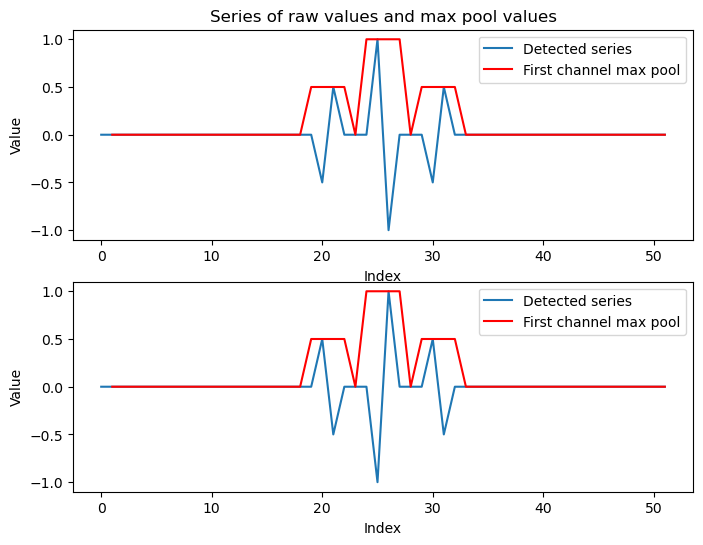

In [2]:
def plot_pool(series1, series2, pool1, pool2):
    x = list(range(series1.shape[0]))
    end = series1.shape[0]
    end_pool = pool1.shape[0]
    end_remain = end % end_pool
    pool_stride = int((end_pool - end_remain)/end_pool) + 1
    x_pool = list(range(end_remain, end_pool + end_remain, pool_stride))
    
    fig,ax = plt.subplots(2, 1, figsize=(8,6))
    ## First channel
    ax[0].plot(x, series1, label = 'Detected series')
    ax[0].plot(x_pool, pool1, color = 'red', label = 'First channel max pool')
    ax[0].set_title('Series of raw values and max pool values')
    ax[0].legend()
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Value') 
    ## Second channel
    ax[1].plot(x, series2, label = 'Detected series')
    ax[1].plot(x_pool, pool1, color = 'red', label = 'First channel max pool')
    ax[1].legend()
    ax[1].set_xlabel('Index')
    ax[1].set_ylabel('Value') 
    
nr.seed(12233)
series1 = np.concatenate((np.zeros((20,)), np.zeros((5,)) + 1.0, np.zeros((5,)) - 1.0, np.zeros((20,))))

def max_pool(series, span=3):
    '''Performs simple 1d max pooling with
    an operator over span and stride 1'''
    ## Your code goes below
    




> 6. Define and apply new 5-point convolution kernels for the edge detection, $[-0.25, - 0.25, 1.0, -0.25, -0.25]$ and $[0.25, 0.25, -1.0, 0.25, 0.25]$. 
> 7. Apply the max pooling with kernel span of 5 to both of the edge detection series.  
> 8. Display the results.  

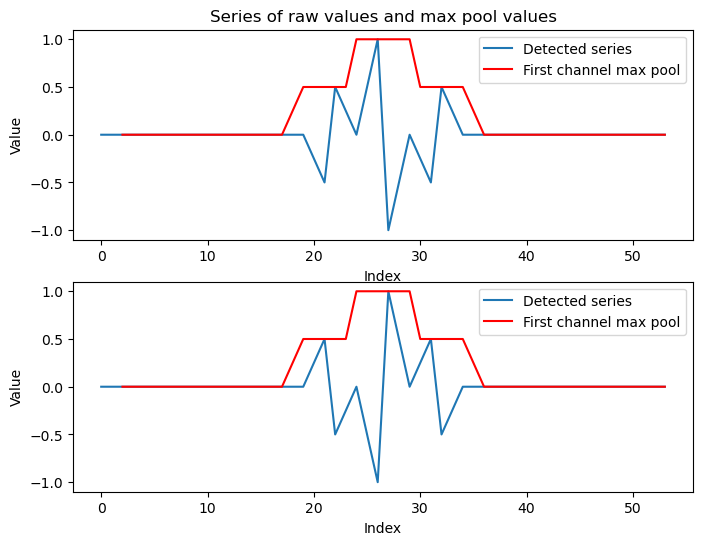

> Examine these results and answer these questions in one or a few sentances:   
> 1. How does the max-pooling operator with span of  preserve edges in the convolution output series?     
> 2. Haw can you explain the invariance of the max-pooling results to the sign of the input series.  
> 3. How can you explain the difference in the edge detection series and the max-pooled values between the two kernel spans in terms of the receptive field of the operator?    
> **End of exercise**.   

> **Answers:**    
> 1. The pooled series shows the maximum absolute values within the span of the pooling operator which preserves maximums at the edges, or rapid transitions of the input signal. 
> 2. Max pooling uses absolute values, and is invariant to the sign of the convolution result.     
> 3. The operations with kernel span of 5 have a larger receptive field that for kernel span of 3. The larger receptive field has the effect of elongating the edge regions detected and producing wider maximum regions from the max pooling.   

## 2.0 Convolutional neural networks with Keras

With the foregoing theory and simple examples, let's try constructing and testing a convolutional neural network using Keras. In this case, we will test classification of of the MNIST dataset. The neural network will have the following layers:
1. An input layer for the 28X28 images.
2. A multi-layer convolutional neural network to create a feature map.
3. A fully-connected hidden layer to perform the classification.
4. A output layer to indicate which digit is most likely. 

### 2.1 Preparing the dataset

The preparation of this dataset is follows nearly identical steps to the process followed in an earlier lesson. In summary, three preparation steps are performed:
1. Load the training and test image data and labels.
2. Reshape the image tensors so the neural network views them as a 4-d tensor. For the training images the tensor has a shape of (60000,28,28,1) corresponding to 60000 images of dimension $28 \times 28$ with a single channel (these are gray-scale images). At the same time the pixel values are converted to `float` type in the range $\{ 0,1 \}$.
3. The labels are recoded as dummy variables using the Keras [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float')/255
print(train_images.shape)
print(train_images.dtype)

(60000, 28, 28, 1)
float64


In [6]:
print(test_images.shape, test_labels.shape)
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float')/255
print(test_images.shape)

(10000, 28, 28) (10000,)
(10000, 28, 28, 1)


In [7]:
train_labels = ku.to_categorical(train_labels)
print(train_labels[5:,])

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [8]:
test_labels = ku.to_categorical(test_labels)

Notice the one-hot encoding of the labels. There is one dummy variable (column) for each label value, $\{0,...,9\}$. 

### 2.2 Defining the model. 

It is now time to define the model. 

> Early stopping regularization is an old idea in machine learning. The concept is simple, stop learning at the point the model starts to over-fit. Early stopping measures learning with a single selected validation metric. The early stopping algorithm can be describe as follows, using a validation metric like validation error rate or validation loss rate.    

As a first step, the callbacks required to implement early stopping regularization are defined. The steps to define the [early stopping call backs with Kera](https://keras.io/api/callbacks/early_stopping/) are:    
1. Define a path to an HDF5 file used to save the training history. 
2. The first callback stops the training when the validation loss does not improve within 4 epochs, the patience.  
3. The second callback saves the model weights resulting from the epoch with the best validation loss.  

In [9]:
## Set up and call-backs for early stopping
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
        callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 5 # Stop after patience steps with lower accuracy
        ),
        callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True # Only save model if it is the best
        )
]


> **Exercise 6-2:** You will now use Keras to define the CovNet model named `nn`. This model uses both convolutional layers and max pooling layers. You will define this model by completing the function in the code cell below. You can find [documentation on the Keras convolutional layers here](https://keras.io/layers/convolutional/). You can find [documentaton on Keras pooling layers here](https://keras.io/layers/pooling/).
> The architecture of the model you will create is:
> 1. A 3X3 convolutional layer with 32 output channels using the [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2D/) function, with `activation='relu'`. Recall that this operation creates a feature map with 32 channels from the single gray-scale input channel. This is the input layer of the model, so make sure you define the input shape. 
> 2. A 2X2 max pooling layer using the [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) function.
> 3. A dropout layer is used to improve regularization of the model using the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) function with argument 0.2. 
> 3. A 3X3 convolution layer with 64 output channels, with `activation='relu'`. The 32 channels of the input layer are mapped to a 64 channel feature map. 
> 4. Another 2X2 max pooling layer. 
> 5. A dropout layer to improve regularization of the model with argument 0.2. 
> 6. A final 3X3 convolution layer with 64 output channels, with `activation='relu'`. 
> 7. A dropout layer to improve regularization of the model with argument 0.2. 
> 8. Flatten the 64 channel feature map to a vector.
> 9. A Dense (fully-connected) hidden layer with 64 units is the first classifier layer, with `activation='relu'`. A limited amount of regularization is applied using Keras [layer regularizer l2](https://keras.io/api/layers/regularizers/) as a ` kernel_regularizer`, with hyperparameter 0.1. This layer operates on the flattened feature map. 
> 10. A dropout layer to improve regularization of the model with argument 0.5. 
> 11. The output Dense layer has 10 units with `activation='softmax'` to indicate the classification of the digits.
> 12. A summary of the model is printed.
> 13. The model object is returned. 
> Execute your code and examine the summary of the model. 

In [10]:
def create_model(): 
    ## Your code goes below
    

nn = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

> There is quite bit of interesting information in the summary of this model. In one or a few sentances answer the following questions:
> 1. How does the dimensionality of the feature map change at each convolution and max pooling layer? 
> 2. Compare the number of parameters of your CovNet model to the fully connected model you created for exercise 5-4. How different is the overall number of parameters and layers? 
> 3. What does the difference in the numbers of parameters between the CovNet and the fully connected model tell you about the ability to train these models with a finite amount of data? 
> 4. How many learnable parameters do the max-pooling layers have, and why?    
> **End of exercise**. 


> **Answers:** 
> 1.     
> 2.     
> 3.      
> 4.     

### 2.3 Train and test the model

Now, it is time to compile and fit your model. This particular model appears to require only limited regularization. The table below shows the limited heuristic search performed on the hyperparamters.

| Final Accuracy  | Dropout  | weight decay | Learning Rate |   
| --------------- | -------- | ------------ | ------------- |
| 0.9923          | 0.2      | 0.00         | 0.001        |
| 0.9923          | 0.2      | 0.001         | 0.001        |
| 0.9890          | 0.5      | 0.001         | 0.001        |


The code in the cell below compiles the model using the chosen optimizer with learning rate and weight decay hyperparameters selected. The model is then fit and the history is captured. Run the code in the cell below, which may take some time. 

In [11]:
## Compile the model
nn.compile(optimizer=RMSprop(learning_rate=0.001, decay=0.001), 
           loss = 'categorical_crossentropy', metrics = ['accuracy', 'top_k_categorical_accuracy'])

## Now fit the model
history = nn.fit(train_images, train_labels, 
                  epochs = 80, batch_size = 256,
                  validation_data = (test_images, test_labels),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 1)

Epoch 1/80
235/235 [==============================] - 13s 54ms/step - loss: 2.0448 - accuracy: 0.7849 - top_k_categorical_accuracy: 0.9678 - val_loss: 0.2900 - val_accuracy: 0.9528 - val_top_k_categorical_accuracy: 0.9995
Epoch 2/80
235/235 [==============================] - 13s 56ms/step - loss: 0.3378 - accuracy: 0.9339 - top_k_categorical_accuracy: 0.9971 - val_loss: 0.1717 - val_accuracy: 0.9733 - val_top_k_categorical_accuracy: 0.9998
Epoch 3/80
235/235 [==============================] - 14s 57ms/step - loss: 0.2564 - accuracy: 0.9501 - top_k_categorical_accuracy: 0.9982 - val_loss: 0.1608 - val_accuracy: 0.9723 - val_top_k_categorical_accuracy: 0.9999
Epoch 4/80
235/235 [==============================] - 14s 58ms/step - loss: 0.2166 - accuracy: 0.9578 - top_k_categorical_accuracy: 0.9985 - val_loss: 0.1261 - val_accuracy: 0.9811 - val_top_k_categorical_accuracy: 0.9996
Epoch 5/80
235/235 [==============================] - 14s 60ms/step - loss: 0.1937 - accuracy: 0.9626 - top_k_ca

Run the code in the cells below to plot the loss and accuracy history vs. epoch.

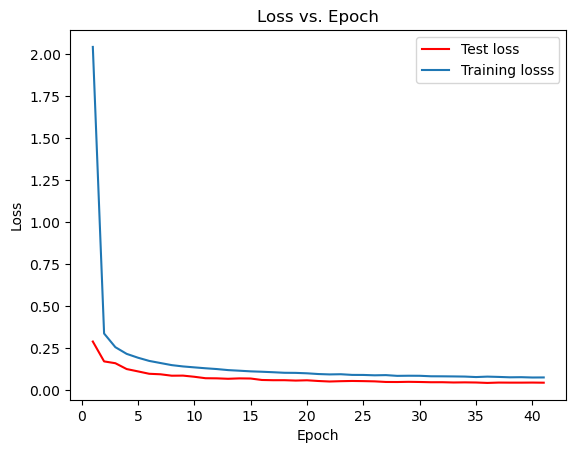

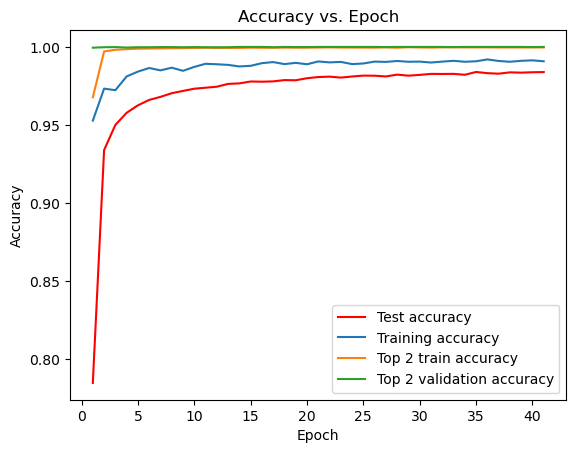

In [12]:
def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'Test loss')
    plt.plot(x, train_loss, label = 'Training losss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.show()
    
def plot_accuracy(history):
    x = list(range(1, len(history.history['accuracy']) + 1))
    plt.plot(x, history.history['accuracy'], color = 'red', label = 'Test accuracy')
    plt.plot(x, history.history['val_accuracy'], label = 'Training accuracy')
    plt.plot(x, history.history['top_k_categorical_accuracy'], label = 'Top 2 train accuracy')
    plt.plot(x, history.history['val_top_k_categorical_accuracy'], label = 'Top 2 validation accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')      
    plt.show()
    
plot_loss(history)    
plot_accuracy(history)   

> **Exercise 6-3:** Examine these results and answer the following questions:    
> 1. How does the accuracy and error rate of your CovNet model compare to the regularized fully connected model of Exercise 5-10 of the previous assignment?
> 2. How can you characterize the convergence or learning rate of the CovNet model after the first 10 epochs.     

> **Answers:**   
> 1.      
> 2.    

Now you will continue with the evaluation of the model. One can compute several possible accuracy metrics.    

First, you will use conventaional or **top-1** accuracy along with **top-k** accuracy, in this case top-2. Top-1 accuracy measures the fraction of cases where the correct category is predicted. Top-k accuracy measures the fraction of cases where the correct category is in the top k probabilities of categories. Since there are only 10 categories for this problem we are limiting to $k=2$. For cases with many categories it is common to use top-5 accuracy.    

You will also compute and display the mean average precision and mean average recall.  

Execute this code in the cell below to compute and display these accuracy metrics along with average precision and average recall.    

313/313 [==============================] - 1s 4ms/step
Categorical accuracy = 0.9908
Top 2 accuracy = 0.9988
Average precision = 0.9908
Average recall = 0.9908
Confusion matrix
     0     1     2     3    4    5    6     7    8    9
0  975     0     1     0    0    0    1     1    2    0
1    0  1129     2     2    0    0    1     1    0    0
2    0     0  1029     0    0    0    0     2    1    0
3    0     0     1  1001    0    3    0     4    1    0
4    0     0     1     0  973    0    4     0    0    4
5    2     0     0     6    0  879    1     1    1    2
6    6     2     1     0    1    2  945     0    1    0
7    0     1     5     0    0    0    0  1019    0    3
8    2     0     2     1    0    0    0     3  961    5
9    3     1     0     0    4    1    0     2    1  997


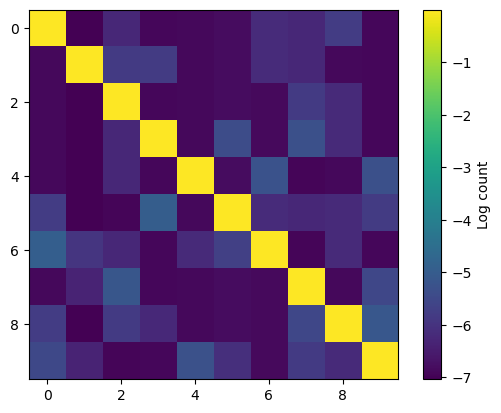

In [13]:
def evaluate_model(model, test_imges, test_labels):   
    ## Compute class predictions
    class_probabilities = model.predict(test_images)
    class_predictions = class_probabilities.argmax(axis=1)
    
    ## Compute the top-1 categorical accuacy.  
    categorical_accuracy = CategoricalAccuracy()
    categorical_accuracy.update_state(test_labels, class_probabilities)

    # Compute the top-2 accuracy.  
    top_2_accuracy = TopKCategoricalAccuracy(k=2, name='top_2_categorical_accuracy')
    top_2_accuracy.update_state(test_labels, class_probabilities)

    ## Summarize and print the result.   
    print('Categorical accuracy = ' + str(categorical_accuracy.result().numpy()))
    print('Top 2 accuracy = ' + str(top_2_accuracy.result().numpy()))

    ## Get the class labels, counts and compute the class-specific recall and precision.  
    test_labels_vector = test_labels.argmax(axis=1)
    unique_labels, label_counts = np.unique(test_labels_vector, return_counts=True)
    class_precision = metrics.precision_score(test_labels_vector, class_predictions, labels=unique_labels, average=None)
    class_recall = metrics.recall_score(test_labels_vector, class_predictions, labels=unique_labels, average=None)

    ## Comptue and print the mean average precision and recall accounting for class frequency weights
    sum_label_counts = np.sum(label_counts)
    weighted_average = lambda x: round(np.sum(np.divide(x * label_counts, sum_label_counts)), 4)
    print('Average precision = ' + str(weighted_average(class_precision)))
    print('Average recall = ' + str(weighted_average(class_recall)))

    ## Compute, display and plot the confusion matrix.  
    confusion_matrix = metrics.confusion_matrix(test_labels_vector, class_predictions)   
    print('\nConfusion matrix')
    print(pd.DataFrame(confusion_matrix))
    p = plt.imshow(np.log(np.divide(confusion_matrix + 1.0, np.sum(confusion_matrix, axis=1))))
    cb = plt.colorbar(p)
    _=cb.set_label('Log count')

evaluate_model(nn, test_images, test_labels)

> **Exercise 6-4:** Examine the evaluation metrics of the model. Notice that the accuarcy, mean average precision and mean average recall are all high. Now, answer these questions:    
> 1. Consider the differences between the top-1 (categoracal) accuraccy and top-2 accuracy. Is the difference expected for this model and why?   
> 2. Why are average precision and average recall values computed expected for this model?   

> **Answers:**     
> 1.         
> 2.     

## 3.0 What features does the convolutional neural network learn?

You might well ask, what is in the various layers of the feature map? It turns out, we can actually visualize the output from each layer of the convolutional neural network to get a feel for the learned features. This can be done for both convolutional and max pooling layers.

As a first step we must pick and image used as the test case. For this example, we arbitrarily choose the 13th image in the training tensor. Execute the code in the cell below to visualize this image. 

(28, 28, 1)


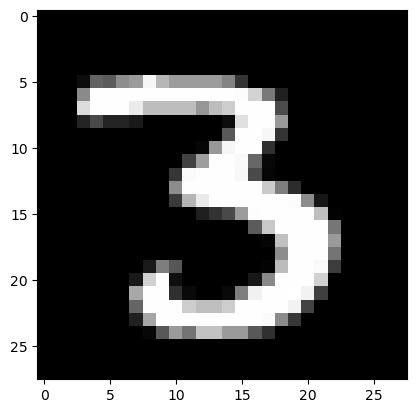

In [14]:
img = train_images[12,:,:,:]
print(img.shape)
plt.imshow(img.reshape((28,28)), cmap = 'gray')

Our sample image turns out to be a number 3. 

The code in cell below does the following:
1. Extracts the layers from the model object into a list. 
2. Creates an activation map for each layer using the original model object and the list of layer outputs. 
3. Computes the activations for each layer by applying the predict method to the activation map. 

Execute this code to create a list of activations for the convolutional neural network. 

In [15]:
layer_outputs = [layer.output for layer in nn.layers[:7]]
activation_model = models.Model(inputs = nn.input, outputs = layer_outputs)
activations = activation_model.predict(img.reshape(1,28,28,1))

1/1 [==============================] - 0s 49ms/step


The code in the cell below does the following:
1. Iterates through the activation maps of the first 5 model layers.
2. Iterates over the activation map channels in the layer displaying the image. There is one image for each channel in the feature map. 

Execute this code and examine the result.

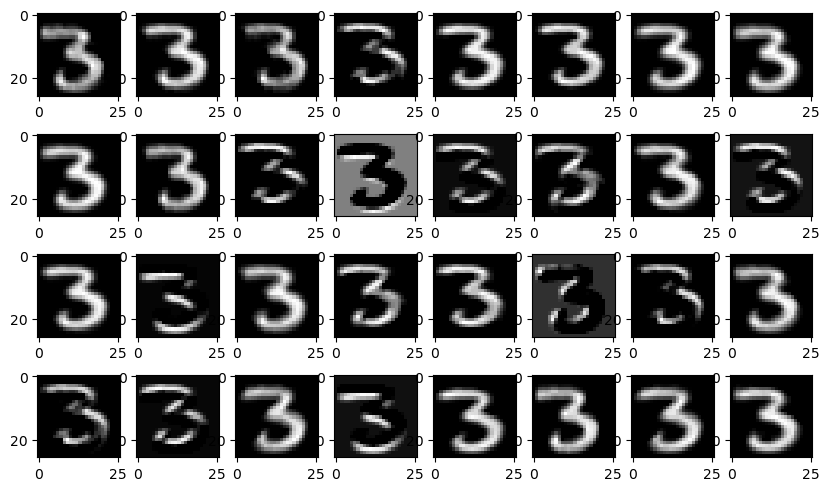

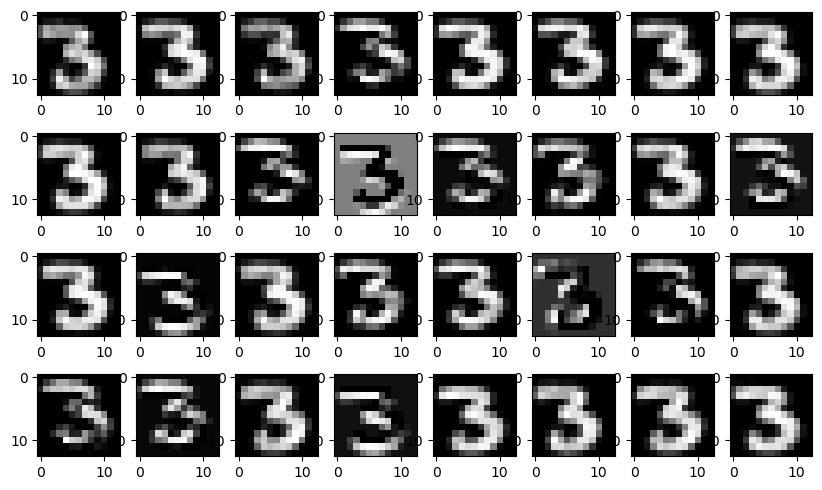

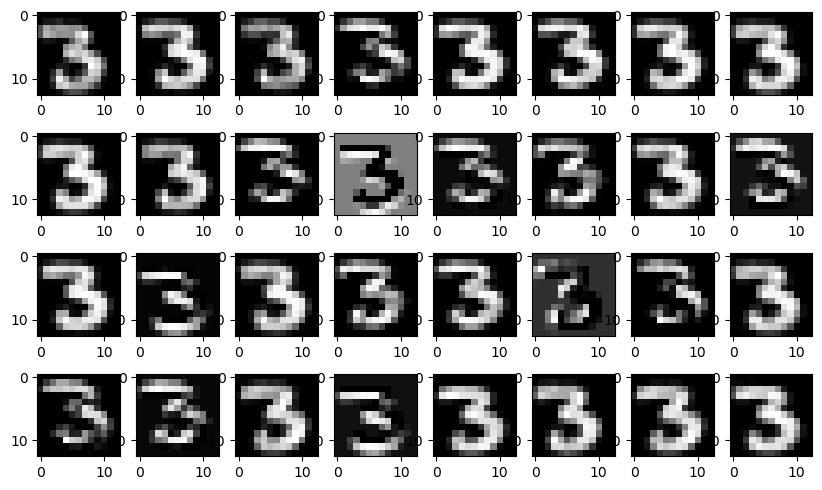

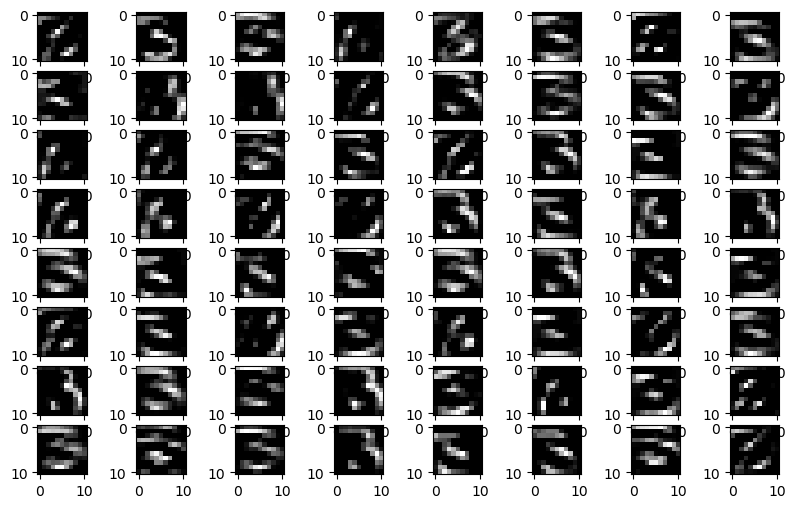

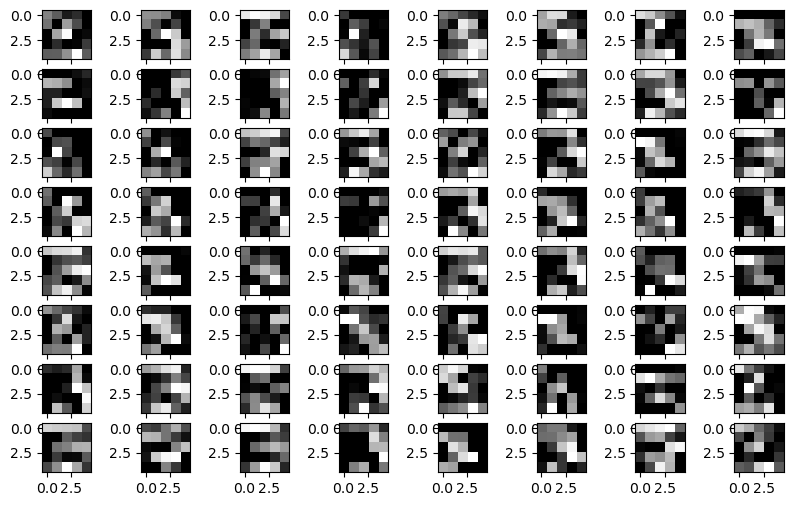

In [16]:
for j in range(5):
    fig_shape = activations[j].shape
    s = fig_shape[3]/32
    fig = plt.figure(figsize=(10,6))
    for i in range(fig_shape[3]):
        ax = fig.add_subplot(int(s*4),8,(i+1))
        plt.imshow(activations[j].reshape((fig_shape[1],fig_shape[2],fig_shape[3]))[:,:,i], cmap='gray')

> **Exercise 6-5:** Examine the above sets of images. There are 5 sets of images, one for each of the output of the first 5 layers of the model. For each layer, there is an image showing each channel of the feature map. Keeping in mind that CNNs are known to be effective as finding find-grain features, in one or a few sentences, answer the following questions: 
> 1. The initial single channel $28 \times 28 \times 1$ input image tensor becomes a $32 \times 26 \times 26 \times 1$, 32 channel feature map after the first convolution. The second $32 \times 13 \times 13 \times 1$ output is from the max-pooling layer. In general terms, describe how much these feature maps resemble the original image, and why do you think this might be the case given the receptive field of the kernels?    
> 2. Examine the feature maps created by the forth (convolution), fith (max-pooling), and seventh (convolution) layers. How can you best describe the level of abstraction of these layers and the the resemblance to the original image?      
> 3. What effect can you observe of using the max-pooling layer other than dimensionality reduction, and why?  
> 4. WHat relationship can you identify between the spatial dimensionality of the feature map and the level of abstraction and localization of the features? 
> **End of exercise**.  

> **Answers:**
> 1.    
> 2.     
> 3.     
> 4.    

## 4.0 Padding convolution

As you have observed, each convolution layer in a neural network reduces the spatial dimensions by $\frac{span+1}{2}$ for odd span kernels. The coverage of the convolution opertor can be expanded by **zero padding** in the spatial dimenstion. With the zero padding added, the convolution operator covers the entire spatial dimension of the input tensor. This type of convolution is sometime referred to as **same convolution**, since the output tensor has the same spatial dimensions. 

In some situations, adding zero padding produces a better feature map. Zero padding allows each pixel to be visited the same number of times by the convolution operator. Without padding pixels at the edge, are not full represented in the feature map. More importantly, the larger feature map will have bigger model capacity. 

2-d convolution with zero padding is illustrated in Figure 4.1 below. The original input 2-d input tensor is shown in gray. The span of the kernel is 3X3 so one additional column of zeros is added to each sided along with a row of zeros top and bottom. As illustrated, the kernel can operate on the edge pixels. The result is an output tensor with the same spatial dimension as the input. 

![](img/Padding.JPG)
<center>**Figure 4.1. 2-d convolution with zero padding**</center>

> **Exercise 6-6:** With Keras, adding zero padding to convolutional layers is easy. The `padding = same` argument adds zero padding. The default is `padding = valid` adds no padding. Create a new model, with a new name 'nns', with the same layers as the foregoing model, and a dropout rate of 0.2, but with the `padding = same` argument for the convolutional layers.  Then print the summary of the model.  

In [21]:
## Your code goes below




nns.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 64)         

> Examine the summary of your model and answer these questions:   
> 1. The final feature map is $64 \times 7 \times 7$, rather than $64 \times 3 \times 3$ for the model without padding. This feature map has 49 pixels per channel, compared to 9 pixels per channel previously. Do you expect that this feature map will contain more information and why? 
> 2. How has the number of parameters changed for the convolutional layer, and is this expected? 
> 3. Compare the number of learnable parameters for the 64 unit fully connected layer between the models with and without padding. How can you account for this difference? 
> **End of exercise**. 

**Answers:**   
> 1.     
> 2.     
> 3.     

Next execute the code in the cell below to compile and fit the model. This process will take some time. 

In [22]:
## Compile the model
nns.compile(optimizer=RMSprop(learning_rate=0.001, decay=0.001), 
            loss = 'categorical_crossentropy', metrics = ['accuracy', 'top_k_categorical_accuracy'])
    
## Now fit the model
history_s = nns.fit(train_images, train_labels, 
                  epochs = 80, batch_size = 256,
                  validation_data = (test_images, test_labels),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 1)

Epoch 1/80
235/235 [==============================] - 19s 78ms/step - loss: 1.3158 - accuracy: 0.8079 - top_k_categorical_accuracy: 0.9720 - val_loss: 0.3258 - val_accuracy: 0.9505 - val_top_k_categorical_accuracy: 0.9992
Epoch 2/80
235/235 [==============================] - 18s 79ms/step - loss: 0.3906 - accuracy: 0.9296 - top_k_categorical_accuracy: 0.9972 - val_loss: 0.2460 - val_accuracy: 0.9641 - val_top_k_categorical_accuracy: 0.9999
Epoch 3/80
235/235 [==============================] - 19s 83ms/step - loss: 0.3082 - accuracy: 0.9455 - top_k_categorical_accuracy: 0.9980 - val_loss: 0.1773 - val_accuracy: 0.9773 - val_top_k_categorical_accuracy: 0.9999
Epoch 4/80
235/235 [==============================] - 20s 83ms/step - loss: 0.2614 - accuracy: 0.9548 - top_k_categorical_accuracy: 0.9985 - val_loss: 0.1692 - val_accuracy: 0.9756 - val_top_k_categorical_accuracy: 0.9998
Epoch 5/80
235/235 [==============================] - 20s 86ms/step - loss: 0.2346 - accuracy: 0.9591 - top_k_ca

Next, execute the code in the cells below to plot the loss vs. epoch and accuracy vs. epoch.

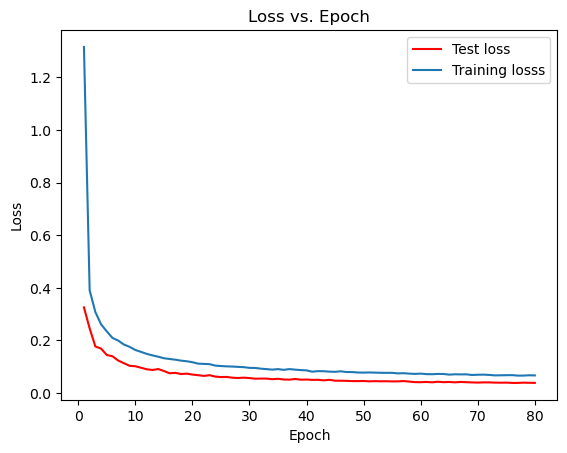

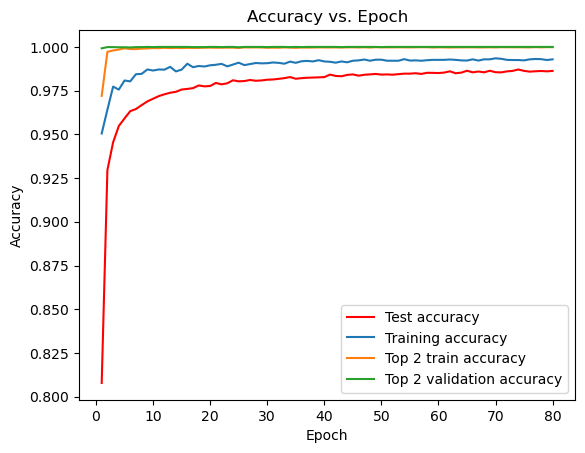

In [23]:
plot_loss(history_s)    
plot_accuracy(history_s) 

313/313 [==============================] - 2s 6ms/step
Categorical accuracy = 0.9929
Top 2 accuracy = 0.9991
Average precision = 0.9929
Average recall = 0.9929
Confusion matrix
     0     1     2     3    4    5    6     7    8    9
0  976     0     0     0    0    0    1     1    2    0
1    0  1130     2     0    0    1    0     1    1    0
2    0     1  1025     0    0    0    0     3    3    0
3    0     0     1  1003    0    3    0     1    2    0
4    0     0     0     0  979    0    0     0    0    3
5    1     0     0     3    0  885    1     1    1    0
6    4     2     0     0    1    0  951     0    0    0
7    0     2     2     1    0    0    0  1020    1    2
8    3     0     2     1    0    1    1     0  964    2
9    0     2     0     0    4    2    0     2    3  996


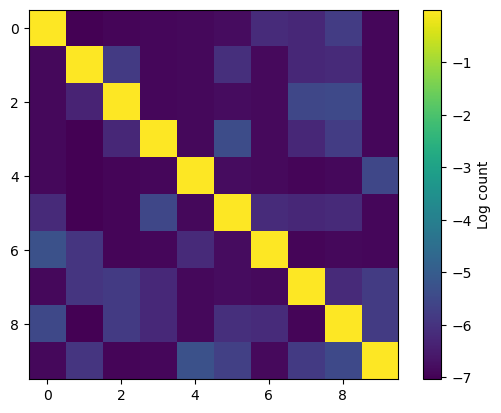

In [24]:
## Display accuracy netrics
evaluate_model(nns, test_images, test_labels)

> **Exercise 6-7:** Keeping in mind that small (3rd digit) differences in metrics are often simply a result of random sampling do these results appear significantly difference than for the unpadded model? It may well be the case that richer feature map may not be important for this relatively simple problem. 

> **Answer:**     

## Variable Learning Rate     

The two foregoing models have been trained using a fixed learning rate. In many cases a fixed learning rate is far from optimal. The problem arrises since initial learning can take large steps, but small steps are required toward convergence to ensure a stabble termination of the algorithm. A fixed low learing rate will learn too slowing a the begining of training but converge at the end. On the other hard a high learning rate is effcive at the beginign of traning, but will lead to poor or unstable convergence.   

The solution is to use a variable learning rate. The variable learning rate decreases at the training proceeds. In this way, the learning rate can be optimized to ensure the fastest posslble convergence of the learning. The variable learning rate is determined by a schedule. Common schedules include lenear decreases and exponential decreases. Keras supports a number of [learning rate schedulers](https://keras.io/api/optimizers/learning_rate_schedules/).      

> **Exercise 6-8:** You will now investigate using a variable learning rate for training the CNN model. The code in the cell bellow does the following:  
> 1. An exponentially decay learning rate schedule is created using [tensorflow.keras.optimizers.schedules.ExponentialDecay](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/). 
> 2. The `nnv` model is instantiated, using the function you created earlier, and compiled. A learning rate schedule can be incorporated into most Keras optimizers. In this case, the [RMSprop optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop) has an `learning_rate` argument set to the learning rate just created, and with `decay=0.001`.    
> 3. The model is fit using 80 epochs, or untill the stopping criteria set in the call-back function is reached. The larger number of epochs allow the training to run closer to completion.    
> 
> Execute this code to traing the model, which will take some time to run.

> **Note:** You may be wondering why a new model needs to be instantiated to run this experiement. The reason is that Keras (nd Tensorflow) model objects will retain any weight values from previous learning. This property can be an advantage if one wishes to do additional training. For example, additional training can be performed when additional data is avaialable, without starting over again. Hoeever, if one wishes to run an independent experiment, as we do here, it is best to instantiate a new model object.    

In [26]:
## Define the learning rate schedule 
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, 
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

## Instantiate and compile the model
nnv = create_model()
nnv.compile(optimizer = RMSprop(learning_rate=lr_schedule, decay=0.001),
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy', 'top_k_categorical_accuracy'])
    
## Now fit the model
history_v = nnv.fit(train_images, train_labels, 
                  epochs = 80, batch_size = 256,
                  validation_data = (test_images, test_labels),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 5, 5, 64)         

> Next execute the code in the cell below to evalue the model just trained.   

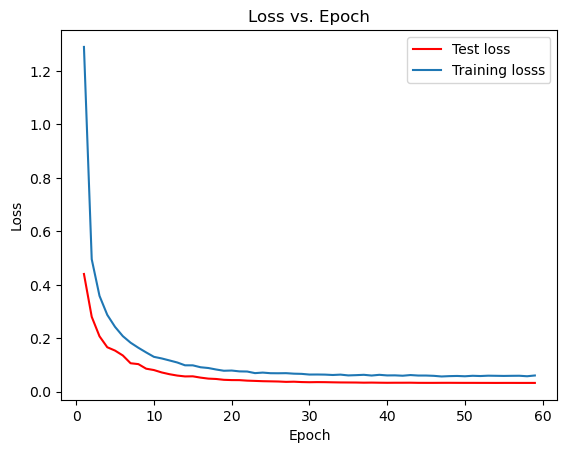

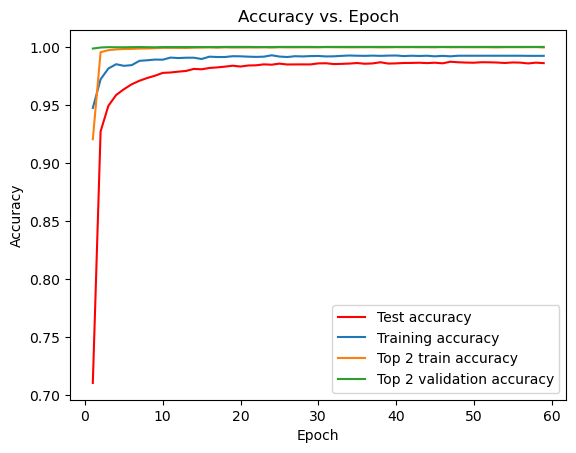

313/313 [==============================] - 1s 4ms/step
Categorical accuracy = 0.9923
Top 2 accuracy = 0.9989
Average precision = 0.9923
Average recall = 0.9923
Confusion matrix
     0     1     2     3    4    5    6     7    8    9
0  977     0     0     0    1    0    1     1    0    0
1    0  1132     0     3    0    0    0     0    0    0
2    1     1  1026     0    0    0    0     3    1    0
3    0     0     1  1005    0    3    0     1    0    0
4    0     0     0     0  972    0    4     0    0    6
5    1     0     0     4    0  885    1     1    0    0
6    5     2     0     0    1    2  947     0    1    0
7    0     2     4     1    1    1    0  1018    0    1
8    2     0     3     0    1    0    0     0  965    3
9    2     0     0     1    2    3    0     4    1  996


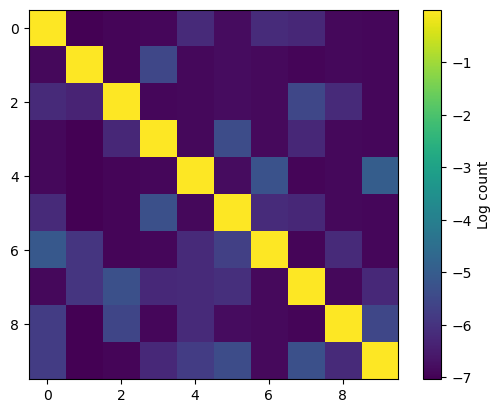

In [27]:
plot_loss(history_v)    
plot_accuracy(history_v) 

## Display accuracy netrics
evaluate_model(nnv, test_images, test_labels)   

> Examine the results and compare them to those created for Exercise 6-3.      
> 1. Comare the number of epochs that occur before reaching the early stopping criteria. What does this differnece tell you about the effect of using a decaying learning rate?    
> 2. How can you explain the improved model performance given the decaying learning rate?   

> **Answers:**   
> 1.    
> 2.            

## Summary

In these exercises you have applied convolutional neural networks (CNNs) to an image calassification problem. Some key points of this lesson are:     
1. CNNs learn powerful features from images.
2. Convolutional feature maps have multiple channels with a spatial dimensions.      
3. Multi-layer CNNs create highly absract features at deeper layers. Deeper architectures can learn more powerful features.
4. The convolutional feature map is used as an input to a classifier.
5. Evaluation of multi-class classifiers can be evaluated by both top-1 and top-k accuacy metrics.   

#### Copyright  2018, 2019, 2020, 2021, 2022, 2023, 2024, Stephen F Elston. All rights reserved.